In [1]:
import numpy as np 
import polars as pl
from scipy.stats import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from arjun_plot.utils import *
import pingouin as pg

plt.rcParams['font.family'] = 'Arial'

%matplotlib inline

In [2]:
mat_co_counts = pl.read_csv('../analysis/co_post_process/results/v30b_heuristic_90_nsib_qual.crossover_filt.deCode_haldorsson19.crossover_count.maternal.euploid.csv.gz', null_values=['NA'])
pat_co_counts = pl.read_csv('../analysis/co_post_process/results/v30b_heuristic_90_nsib_qual.crossover_filt.deCode_haldorsson19.crossover_count.paternal.euploid.csv.gz', null_values=['NA'])

In [3]:
mat_co_counts.head()

chrom,uid,IID,nco,patient_age,egg_donor,sperm_donor,avg_pi0,avg_sigma,maternal_meiotic_aneuploidy,mother_right,father,child,sigma_baf,pi0_baf,0,1m,1p,2,3m,3p,bf_max,bf_max_cat,prop01_exp_het,bf_bph_centro,bf_sph_centro,post_bph_centro,post_sph_centro,bf_bph_noncentro,bf_sph_noncentro,post_bph_noncentro,post_sph_noncentro,post_entropy,post_max,sigma_embryo_mean,day3_embryo,embryo_noise_3sd,meiotic,low-mosaic,high-mosaic,cM_len,End,Begin,seq_len,FID,Sex,Age,AVGPI0,AVGSIGMA,NEMBRYO,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
str,str,str,i64,f64,f64,f64,f64,f64,bool,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,str,str,str,str,str,str,str,str,f64,f64,f64,bool,bool,str,str,str,f64,i64,i64,i64,str,i64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""chr16""","""10005770025_R06C01+10005770025…","""10005770025_R06C01""",1,43.241096,0.0,0.0,0.523948,0.178105,false,"""10005770025_R06C01""","""10005770025_R05C01""","""3999947101_R01C01""",0.178105,0.523948,0.004227,0.000034,0.000026,0.9373,0.023418,0.034995,74.744658,2,0.013592,null,null,null,null,null,null,null,null,0.289664,0.9373,0.155784,false,false,null,null,null,126.58805,89582172,548838,89033334,"""10005770025_R06C01""",0,43.241096,0.565934,0.156446,1,0.002952,0.000211,-0.000784,0.001558,-0.003026,-0.000376,-0.002188,-0.004791,0.003072,0.002094,0.002442,0.000866,0.003571,-0.007647,-0.002837,-0.004159,0.002491,0.001571,-0.002107,0.002705
"""chr14""","""10005770025_R06C01+10005770025…","""10005770025_R06C01""",3,43.241096,0.0,0.0,0.564316,0.148106,false,"""10005770025_R06C01""","""10005770025_R05C01""","""3999947101_R01C01""",0.148106,0.564316,0.006518,0.00001,0.000074,0.985189,0.006071,0.002139,332.577395,2,0.006803,null,null,null,null,null,null,null,null,0.092459,0.985189,0.155784,false,false,null,null,null,116.00254,105464069,20430758,85033311,"""10005770025_R06C01""",0,43.241096,0.565934,0.156446,1,0.002952,0.000211,-0.000784,0.001558,-0.003026,-0.000376,-0.002188,-0.004791,0.003072,0.002094,0.002442,0.000866,0.003571,-0.007647,-0.002837,-0.004159,0.002491,0.001571,-0.002107,0.002705
"""chr22""","""10005770025_R06C01+10005770025…","""10005770025_R06C01""",1,43.241096,0.0,0.0,0.476478,0.194153,false,"""10005770025_R06C01""","""10005770025_R05C01""","""3999947101_R01C01""",0.194153,0.476478,1.7640e-9,5.0935e-7,0.000879,0.984461,0.000495,0.014164,316.77128,2,0.024306,null,null,null,null,null,null,null,null,0.085677,0.984461,0.155784,false,false,null,null,null,70.837397,50237533,17076254,33161279,"""10005770025_R06C01""",0,43.241096,0.565934,0.156446,1,0.002952,0.000211,-0.000784,0.001558,-0.003026,-0.000376,-0.002188,-0.004791,0.003072,0.002094,0.002442,0.000866,0.003571,-0.007647,-0.002837,-0.004159,0.002491,0.001571,-0.002107,0.002705
"""chr9""","""10005770025_R06C01+10005770025…","""10005770025_R06C01""",1,43.241096,0.0,0.0,0.595293,0.158107,false,"""10005770025_R06C01""","""10005770025_R05C01""","""3999947101_R01C01""",0.158107,0.595293,0.000295,0.000023,0.000016,0.995287,0.000123,0.004255,1055.956768,2,0.005217,null,null,null,null,null,null,null,null,0.031863,0.995287,0.155784,false,false,null,null,null,157.345126,137658312,689340,136968972,"""10005770025_R06C01""",0,43.241096,0.565934,0.156446,1,0.002952,0.000211,-0.000784,0.001558,-0.003026,-0.000376,-0.002188,-0.004791,0.003072,0.002094,0.002442,0.000866,0.003571,-0.007647,-0.002837,-0.004159,0.002491,0.001571,-0.002107,0.002705
"""chr2""","""10005770025_R06C01+10005770025…","""10005770025_R06C01""",2,43.241096,0.0,0.0,0.587744,0.139999,false,"""10005770025_R06C01""","""10005770025_R05C01""","""3999947101_R01C01""",0.139999,0.587744,0.000373,0.000488,0.000005,0.976755,0.011806,0.010573,210.099703,2,0.006584,null,null,null,null,null,null,null,null,0.130207,0.976755,0.155784,false,false,null,null,null,251.727026,241537572,522921,241014651,"""10005770025_R06C01""",0,43.241096,0.565934,0.156446,1,0.002952,0.000211,-0.00078

In [4]:
def estimate_icc(df, bootstrap=100):
    """Estimate the contribution between different variance components."""
    assert 'nco' in df.columns
    assert 'uid' in df.columns
    valid_ids = df.group_by('uid').agg(pl.col('chrom').unique().len()).filter(pl.col('chrom') == 22)['uid'].to_numpy()
    df_filt = df.filter(pl.col('uid').is_in(valid_ids))
    avar = df_filt.group_by('uid').agg(pl.col('nco').sum())['nco'].var()
    bvar = df_filt.group_by('chrom').agg(pl.col('nco').var().alias('bvar'))['bvar'].sum()
    chroms = df_filt['chrom'].unique().to_numpy()
    cvar = 0.0
    for c1 in tqdm(chroms):
        for c2 in chroms:
            if c1 != c2:
                x1 = df_filt.filter(pl.col('chrom') == c1).select(pl.col('nco').sort_by('uid'))['nco'].to_numpy()
                x2 = df_filt.filter(pl.col('chrom') == c2).select(pl.col('nco').sort_by('uid'))['nco'].to_numpy()
                cvar += np.cov(x1,x2)[0,1]
    return avar, bvar, cvar

estimate_icc(mat_co_counts)

100%|████████████████████████████████████████████████████████████████| 22/22 [00:16<00:00,  1.31it/s]


(154.52064537713088, 50.77873661859193, 103.74190875853886)

In [5]:
estimate_icc(pat_co_counts)

100%|████████████████████████████████████████████████████████████████| 22/22 [00:16<00:00,  1.31it/s]


(105.1849897875972, 35.86071004821996, 69.32427973937735)

In [6]:
103.74190875853877/154.52064537713088, 69.32427973937733/105.1849897875972

(0.6713789507242934, 0.6590700810007746)

In [7]:
def conduct_pooled_simulation(df, nreps=100, seed=42):
    """Conduct a pooled simulation to draw independent chromosomes to create a distribution of nuclei."""
    assert 'nco' in df.columns
    assert 'uid' in df.columns
    assert seed > 0
    np.random.seed(seed)
    nco_rand = np.zeros(nreps)
    valid_ids =  df.group_by('uid').agg(pl.col('chrom').unique().len()).filter(pl.col('chrom') == 22)['uid'].to_numpy()
    df_filt = df.filter(pl.col('uid').is_in(valid_ids))
    true_nco = df_filt.group_by('uid').agg(pl.col('nco').sum())['nco'].to_numpy()
    co_dict = df_filt.group_by('chrom').agg(pl.col('nco')).rows_by_key(key=["chrom"])
    co_dict_alt = {}
    for k in co_dict:
        co_dict_alt[k] = np.array(co_dict[k][0]).flatten()
    chroms = df_filt['chrom'].unique().to_numpy()
    for i in tqdm(range(nreps)):
        for c in chroms:
            nco_rand[i] += np.random.choice(co_dict_alt[c])
    return true_nco, nco_rand

In [8]:
true_nco_mat, nco_rand_mat = conduct_pooled_simulation(mat_co_counts, nreps=mat_co_counts['uid'].unique().to_numpy().size)
true_nco_pat, nco_rand_pat = conduct_pooled_simulation(pat_co_counts, nreps=pat_co_counts['uid'].unique().to_numpy().size)

100%|████████████████████████████████████████████████████████| 46858/46858 [00:09<00:00, 5124.58it/s]


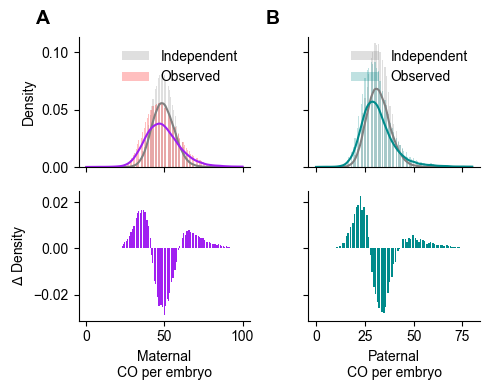

In [9]:
fig, ax = plt.subplots(2,2, figsize=(5,4), sharex='col', sharey='row', layout='tight')
ns_rand, bins, _ = ax[0,0].hist(nco_rand_mat, bins=100, density=True, alpha=0.25, color='gray', label=r'Independent')
ns_true, _, _ = ax[0,0].hist(true_nco_mat, bins=bins, density=True, alpha=0.25, color='red', label=r'Observed');
xs = np.linspace(0,100, 100)
ax[0,0].plot(xs, gaussian_kde(nco_rand_mat).evaluate(xs), color='gray')
ax[0,0].plot(xs, gaussian_kde(true_nco_mat).evaluate(xs), color='#A020F0')
ax[1,0].set_xlabel('Maternal\nCO per embryo')
ax[0,0].legend(frameon=False, fontsize=10)
ax[1,0].bar(bins[:-1], ns_true - ns_rand, color='#A020F0')

ns_rand, bins, _ = ax[0,1].hist(nco_rand_pat, bins=100, density=True, alpha=0.25, color='gray', label=r'Independent')
ns_true, _, _ = ax[0,1].hist(true_nco_pat, bins=bins, density=True, alpha=0.25, color='#008B8B', label=r'Observed');
xs = np.linspace(0,80, 100)
ax[0,1].plot(xs, gaussian_kde(nco_rand_pat).evaluate(xs), color='gray')
ax[0,1].plot(xs, gaussian_kde(true_nco_pat).evaluate(xs), color='#008B8B')
ax[1,1].set_xlabel('Paternal\nCO per embryo')
ax[0,1].legend(frameon=False, fontsize=10)
ax[1,1].bar(bins[:-1], ns_true - ns_rand, color='#008B8B')
[debox(a) for a in ax[0,:]]
[debox(a) for a in ax[1,:]]
label_multipanel([ax[0,0], ax[0,1]], ['A', 'B'], yoff=1.1, xoff=-0.25, fontweight='bold', fontsize=14)
ax[0,0].set_ylabel('Density')
ax[1,0].set_ylabel(r'$\Delta$ Density');
plt.savefig('per_nucleus_co.v2.022725.png', dpi=300, bbox_inches='tight')
plt.savefig('per_nucleus_co.v2.022725.pdf', dpi=300, bbox_inches='tight')

In [10]:
mat_co_counts_pd = mat_co_counts.to_pandas()
mat_co_counts_pd.head()

,chrom,uid,IID,nco,patient_age,egg_donor,sperm_donor,avg_pi0,avg_sigma,maternal_meiotic_aneuploidy,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,chr16,10005770025_R06C01+10005770025_R05C01+39999471...,10005770025_R06C01,1,43.241096,0.0,0.0,0.523948,0.178105,False,...,0.002442,0.000866,0.003571,-0.007647,-0.002837,-0.004159,0.002491,0.001571,-0.002107,0.002705
1,chr14,10005770025_R06C01+10005770025_R05C01+39999471...,10005770025_R06C01,3,43.241096,0.0,0.0,0.564316,0.148106,False,...,0.002442,0.000866,0.003571,-0.007647,-0.002837,-0.004159,0.002491,0.001571,-0.002107,0.002705
2,chr22,10005770025_R06C01+10005770025_R05C01+39999471...,10005770025_R06C01,1,43.241096,0.0,0.0,0.476478,0.194153,False,...,0.002442,0.000866,0.003571,-0.007647,-0.002837,-0.004159,0.002491,0.001571,-0.002107,0.002705
3,chr9,10005770025_R06C01+10005770025_R05C01+39999471...,10005770025_R06C01,1,43.241096,0.0,0.0,0.595293,0.158107,False,...,0.002442,0.000866,0.003571,-0.007647,-0.002837,-0.004159,0.002491,0.001571,-0.002107,0.002705
4,chr2,10005770025_R06C01+10005770025_R05C01+39999471...,10005770025_R06C01,2,43.241096,0.0,0.0,0.587744,0.139999,False,...,0.002442,0.000866,0.003571,-0.007647,-0.002837,-0.004159,0.002491,0.001571,-0.002107,0.002705


In [11]:
pat_co_counts_pd = pat_co_counts.to_pandas()
pat_co_counts_pd.head()

,chrom,uid,IID,nco,partner_age,egg_donor,sperm_donor,avg_pi0,avg_sigma,maternal_meiotic_aneuploidy,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,chr1,10005770025_R06C01+10005770025_R05C01+39999471...,10005770025_R05C01,1,46.394521,0.0,0.0,0.568494,0.152452,False,...,0.009792,0.000413,0.000421,-0.001574,0.004968,0.003218,0.008114,0.00287,-0.002676,0.005357
1,chr2,10005770025_R06C01+10005770025_R05C01+39999471...,10005770025_R05C01,2,46.394521,0.0,0.0,0.587744,0.139999,False,...,0.009792,0.000413,0.000421,-0.001574,0.004968,0.003218,0.008114,0.00287,-0.002676,0.005357
2,chr11,10005770025_R06C01+10005770025_R05C01+39999471...,10005770025_R05C01,2,46.394521,0.0,0.0,0.597006,0.153464,False,...,0.009792,0.000413,0.000421,-0.001574,0.004968,0.003218,0.008114,0.00287,-0.002676,0.005357
3,chr3,10005770025_R06C01+10005770025_R05C01+39999471...,10005770025_R05C01,1,46.394521,0.0,0.0,0.581920,0.141296,False,...,0.009792,0.000413,0.000421,-0.001574,0.004968,0.003218,0.008114,0.00287,-0.002676,0.005357
4,chr22,10005770025_R06C01+10005770025_R05C01+39999471...,10005770025_R05C01,2,46.394521,0.0,0.0,0.476478,0.194153,False,...,0.009792,0.000413,0.000421,-0.001574,0.004968,0.003218,0.008114,0.00287,-0.002676,0.005357


In [12]:
icc_mat = pg.intraclass_corr(data=mat_co_counts_pd, targets='chrom', raters='uid',
                         ratings='nco')
icc_mat.set_index("Type")

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.176253,10026.512462,21,1030810,0.0,"[0.11, 0.3]"
ICC2,Single random raters,0.176254,11107.082843,21,983955,0.0,"[0.11, 0.3]"
ICC3,Single fixed raters,0.191609,11107.082843,21,983955,0.0,"[0.12, 0.33]"
ICC1k,Average raters absolute,0.999900,10026.512462,21,1030810,0.0,"[1.0, 1.0]"
ICC2k,Average random raters,0.999900,11107.082843,21,983955,0.0,"[1.0, 1.0]"
ICC3k,Average fixed raters,0.999910,11107.082843,21,983955,0.0,"[1.0, 1.0]"


In [13]:
icc_pat = pg.intraclass_corr(data=pat_co_counts_pd, targets='chrom', raters='uid',
                         ratings='nco')
icc_pat.set_index("Type")

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.088076,4526.651493,21,1030854,0.0,"[0.05, 0.16]"
ICC2,Single random raters,0.088077,4985.600765,21,983997,0.0,"[0.05, 0.16]"
ICC3,Single fixed raters,0.096149,4985.600765,21,983997,0.0,"[0.06, 0.18]"
ICC1k,Average raters absolute,0.999779,4526.651493,21,1030854,0.0,"[1.0, 1.0]"
ICC2k,Average random raters,0.999779,4985.600765,21,983997,0.0,"[1.0, 1.0]"
ICC3k,Average fixed raters,0.999799,4985.600765,21,983997,0.0,"[1.0, 1.0]"
